<h2><font color='#306998'><center>451 Financial Engineering: Programming Assignment 1</center></font></h2>

---

## Problem Description

In this report, I am applying machine learning design and modeling algorithms, including tree-based ensemble boosting methods, to predict the direction of Salesforce's (CRM) future stock price. My goal is to categorize whether the next day's return will be positive or negative, using engineered features derived from historical price data. 

Given the volatility in the macroenvironment and the AI hype of product and development, predicting a tech stock price has its challenges and it's difficult to navigate for a novice investor. Utilizing public historical stock price, my model will hopefully provide a baseline in future stock price by day.

To capture the trends, I constructed features using lagged values of daily closing prices such as 1 to 7 days, including other key indicators (eg. open, clos
e, high, low prices, and trading volumes. These features are designed to capture short-term patterns and market momentum. 




### Data Preparation and Pipeline
I used Python packages for data manipulation and modeling. I used Polars, a high-performance alternative to Pandas for data manipulation, and Scikit-Learn for machine learning study design and modeling algorithms. 

Rather than creating a csv for historical data, I used sqlite3, a python package, to create a data table. From there, I was able to rename column headers and scale the data back for efficiency in testing the model in later steps of the model. 

In [1]:
import os
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)

# Import Python Packages for data manipulation, data pipelines, and databases
import numpy as np
import pyarrow # foundation for polars
import polars as pl # DataFrame work superior to Pandas

# Plotting
import matplotlib.pyplot as plt
# Display static plots directly in the notebook output 
%matplotlib inline
# create stylized visualizations, including heat maps
import seaborn as sns

# Preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import (RandomizedSearchCV, 
                                    TimeSeriesSplit)
from sklearn.model_selection import cross_validate

# utilized in all possible subsets classification work
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss

# needed for randomized search
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

# metrics in xgboost tuning and final model evaluation
from sklearn.metrics import (accuracy_score,
                             classification_report, 
                             roc_curve, 
                             roc_auc_score,
                             RocCurveDisplay,
                             ConfusionMatrixDisplay,
                             confusion_matrix,
                             precision_score,
                             recall_score,
                             f1_score
                            )

# XGBoost Package... more complete than SciKit-Learn boosting methods
import xgboost as xgb
from xgboost import XGBRegressor, XGBClassifier, plot_importance

# import yfinance as yf  # used earlier to obtain the price series
import yfinance as yf

import warnings
# Suppress warnings for cleaner output
warnings.filterwarnings('ignore') 

### Retrieve Data

I used yfinance to collect all daily historical information of CRM from 2001 to present day. From there, I standardized the columns for programming ease.


In [2]:
import yfinance as yf
import polars as pl
import pandas as pd

ticker = "CRM"
start_date = "2001-01-01"
end_date = "2025-07-11"

# Download data
df = yf.download(ticker, start=start_date, end=end_date, interval="1d")

# Flatten MultiIndex columns (if they exist)
if isinstance(df.columns, pd.MultiIndex):
    df.columns = ['_'.join(filter(None, col)).strip() for col in df.columns.values]

# Convert to Polars
pl_df = pl.from_pandas(df.reset_index())

# Print column names and first few rows
print(pl_df.columns)
print(pl_df.head())


[*********************100%***********************]  1 of 1 completed

['Date', 'Close_CRM', 'High_CRM', 'Low_CRM', 'Open_CRM', 'Volume_CRM']
shape: (5, 6)
┌─────────────────────┬───────────┬──────────┬──────────┬──────────┬────────────┐
│ Date                ┆ Close_CRM ┆ High_CRM ┆ Low_CRM  ┆ Open_CRM ┆ Volume_CRM │
│ ---                 ┆ ---       ┆ ---      ┆ ---      ┆ ---      ┆ ---        │
│ datetime[ns]        ┆ f64       ┆ f64      ┆ f64      ┆ f64      ┆ i64        │
╞═════════════════════╪═══════════╪══════════╪══════════╪══════════╪════════════╡
│ 2004-06-23 00:00:00 ┆ 4.262649  ┆ 4.287431 ┆ 3.655469 ┆ 3.717426 ┆ 43574400   │
│ 2004-06-24 00:00:00 ┆ 4.153604  ┆ 4.384084 ┆ 4.089168 ┆ 4.349388 ┆ 8887200    │
│ 2004-06-25 00:00:00 ┆ 3.915689  ┆ 4.151126 ┆ 3.91321  ┆ 4.091647 ┆ 6710000    │
│ 2004-06-28 00:00:00 ┆ 3.965255  ┆ 4.017298 ┆ 3.826471 ┆ 3.965255 ┆ 2270800    │
│ 2004-06-29 00:00:00 ┆ 4.064385  ┆ 4.138734 ┆ 3.923123 ┆ 3.965254 ┆ 2112000    │
└─────────────────────┴───────────┴──────────┴──────────┴──────────┴────────────┘


### Polars DataFrame Development
The following code cell demonstrates Polars use with the time series DataFrame for my selected ticker, CRM.

In [3]:
import sqlite3
# Your existing feature engineering starts here:
crm = pl_df

crm = crm.with_columns(pl.col('Close_CRM').shift(1).alias('CloseLag1'))
crm = crm.with_columns(pl.col('CloseLag1').shift(1).alias('CloseLag2'))
crm = crm.with_columns(pl.col('CloseLag2').shift(1).alias('CloseLag3'))

crm = crm.with_columns((pl.col('High_CRM') - pl.col('Low_CRM')).alias('HML'))
crm = crm.with_columns(pl.col('HML').shift(1).alias('HMLLag1'))
crm = crm.with_columns(pl.col('HMLLag1').shift(1).alias('HMLLag2'))
crm = crm.with_columns(pl.col('HMLLag2').shift(1).alias('HMLLag3'))

crm = crm.with_columns((pl.col('Open_CRM') - pl.col('Close_CRM')).alias('OMC'))
crm = crm.with_columns(pl.col('OMC').shift(1).alias('OMCLag1'))
crm = crm.with_columns(pl.col('OMCLag1').shift(1).alias('OMCLag2'))
crm = crm.with_columns(pl.col('OMCLag2').shift(1).alias('OMCLag3'))

crm = crm.with_columns(pl.col('Volume_CRM').shift(1).alias('VolumeLag1'))
crm = crm.with_columns(pl.col('VolumeLag1').shift(1).alias('VolumeLag2'))
crm = crm.with_columns(pl.col('VolumeLag2').shift(1).alias('VolumeLag3'))

crm = crm.with_columns(pl.col('CloseLag1').ewm_mean(half_life=1, ignore_nulls=True).alias('CloseEMA2'))
crm = crm.with_columns(pl.col('CloseLag1').ewm_mean(half_life=2, ignore_nulls=True).alias('CloseEMA4'))
crm = crm.with_columns(pl.col('CloseLag1').ewm_mean(half_life=4, ignore_nulls=True).alias('CloseEMA8'))

crm = crm.with_columns((np.log(pl.col('Close_CRM') / pl.col('CloseLag1'))).alias('LogReturn'))

crm = crm.with_columns(
    pl.col('Volume_CRM').cast(pl.Float64).round(0),
    pl.col('VolumeLag1').cast(pl.Float64).round(0),
    pl.col('VolumeLag2').cast(pl.Float64).round(0),
    pl.col('VolumeLag3').cast(pl.Float64).round(0),
)

crm = crm.with_columns(
    pl.col('Open_CRM').round(3),
    pl.col('High_CRM').round(3),
    pl.col('Low_CRM').round(3),
    pl.col('Close_CRM').round(3),
    pl.col('CloseLag1').round(3),
    pl.col('CloseLag2').round(3),
    pl.col('CloseLag3').round(3),
    pl.col('HML').round(3),
    pl.col('HMLLag1').round(3),
    pl.col('HMLLag2').round(3),
    pl.col('HMLLag3').round(3),
    pl.col('OMC').round(3),
    pl.col('OMCLag1').round(3),
    pl.col('OMCLag2').round(3),
    pl.col('OMCLag3').round(3),
    pl.col('CloseEMA2').round(3),
    pl.col('CloseEMA4').round(3),
    pl.col('CloseEMA8').round(3),
)

crm = crm.with_columns(
    pl.when(pl.col('LogReturn') > 0).then(1).otherwise(0).alias('Target')
)

print(crm.schema)

# Save to SQLite

crm_pd = crm.to_pandas()

conn = sqlite3.connect("crm_features.db")
crm_pd.to_sql("crm_features", conn, if_exists="replace", index=False)
conn.close()


Schema([('Date', Datetime(time_unit='ns', time_zone=None)), ('Close_CRM', Float64), ('High_CRM', Float64), ('Low_CRM', Float64), ('Open_CRM', Float64), ('Volume_CRM', Float64), ('CloseLag1', Float64), ('CloseLag2', Float64), ('CloseLag3', Float64), ('HML', Float64), ('HMLLag1', Float64), ('HMLLag2', Float64), ('HMLLag3', Float64), ('OMC', Float64), ('OMCLag1', Float64), ('OMCLag2', Float64), ('OMCLag3', Float64), ('VolumeLag1', Float64), ('VolumeLag2', Float64), ('VolumeLag3', Float64), ('CloseEMA2', Float64), ('CloseEMA4', Float64), ('CloseEMA8', Float64), ('LogReturn', Float64), ('Target', Int32)])


### Descriptive Statistics for Price Features

In [4]:
# Drop the rows with null values such as the initial lag rows
crm = crm.drop_nulls()

# Descriptive statistics
crmStatistics = crm.drop('Date').describe()

print(crmStatistics.columns)

crmStatisticsToPrint = crmStatistics.transpose(include_header=True).drop(['column_1', 'column_5', 'column_7'])

print(crmStatisticsToPrint.schema)

with pl.Config(
    tbl_rows = 60,
    tbl_width_chars = 200,
    tbl_cols = -1,
    float_precision = 3,
    tbl_hide_dataframe_shape = True,
    tbl_hide_column_data_types = True):
    print(crmStatisticsToPrint)



['statistic', 'Close_CRM', 'High_CRM', 'Low_CRM', 'Open_CRM', 'Volume_CRM', 'CloseLag1', 'CloseLag2', 'CloseLag3', 'HML', 'HMLLag1', 'HMLLag2', 'HMLLag3', 'OMC', 'OMCLag1', 'OMCLag2', 'OMCLag3', 'VolumeLag1', 'VolumeLag2', 'VolumeLag3', 'CloseEMA2', 'CloseEMA4', 'CloseEMA8', 'LogReturn', 'Target']
Schema([('column', String), ('column_0', String), ('column_2', String), ('column_3', String), ('column_4', String), ('column_6', String), ('column_8', String)])
┌────────────┬──────────┬───────────────────────┬─────────────────────┬──────────────────────┬───────────────────────┬─────────────────────┐
│ column     ┆ column_0 ┆ column_2              ┆ column_3            ┆ column_4             ┆ column_6              ┆ column_8            │
╞════════════╪══════════╪═══════════════════════╪═════════════════════╪══════════════════════╪═══════════════════════╪═════════════════════╡
│ statistic  ┆ count    ┆ mean                  ┆ std                 ┆ min                  ┆ 50%                   

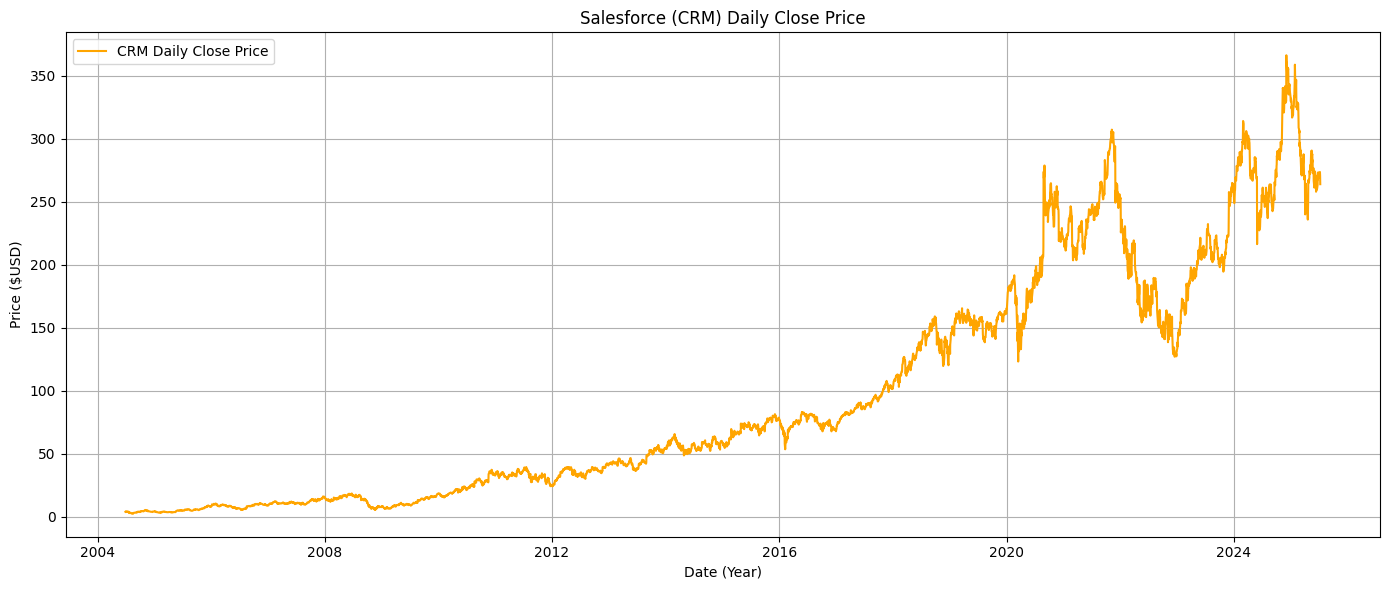

In [5]:

plt.figure(figsize=(14, 6))
plt.plot(crm["Date"], crm["Close_CRM"], label="CRM Daily Close Price", linewidth=1.5, color = 'orange')
plt.title("Salesforce (CRM) Daily Close Price")
plt.xlabel("Date (Year)")
plt.ylabel("Price ($USD)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


## Research Design

Part of my research was 

### Feature List
Features or explanatory variables, also known as an independent variables, are used to predict the values of target variables. The initial list of features includes the price-based features defined above, everything except the continuous response **LogReturn** if we wanted to employ regression and the binary response **Target** for classification, which is the focus of this project. This complete feature list is used in evaluating all methods.

In [6]:
# Select Features for the Model, exclude current day price variables ... no "leakage"
# note for moving averages, we have excluded the current day, and provide a 10-day gap
# so these may be included in the set 
X = crm.drop(['Date', 'LogReturn', 'Target', 'Open_CRM', 'High_CRM', 'Low_CRM', 'Close_CRM', 'Volume_CRM', 'HML', 'OMC'])
X.head()

CloseLag1,CloseLag2,CloseLag3,HMLLag1,HMLLag2,HMLLag3,OMCLag1,OMCLag2,OMCLag3,VolumeLag1,VolumeLag2,VolumeLag3,CloseEMA2,CloseEMA4,CloseEMA8
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
3.916,4.154,4.263,0.238,0.295,0.632,0.176,0.196,-0.545,6.71e6,8.8872e6,4.35744e7,4.033,4.071,4.09
3.965,3.916,4.154,0.191,0.238,0.295,0.0,0.176,0.196,2.2708e6,6.71e6,8.8872e6,3.997,4.029,4.051
4.064,3.965,3.916,0.216,0.191,0.238,-0.099,0.0,0.176,2.112e6,2.2708e6,6.71e6,4.032,4.042,4.054
3.983,4.064,3.965,0.226,0.216,0.191,0.082,-0.099,0.0,2.0876e6,2.112e6,2.2708e6,4.007,4.022,4.037
3.973,3.983,4.064,0.074,0.226,0.216,0.012,0.082,-0.099,1.7548e6,2.0876e6,2.112e6,3.99,4.006,4.022


### Examine the Distribution of LogReturn Values

In [7]:
# Define and examine the target for regression model development
print(crm['LogReturn'].describe())

y = np.array(crm['LogReturn'])


shape: (9, 2)
┌────────────┬───────────┐
│ statistic  ┆ value     │
│ ---        ┆ ---       │
│ str        ┆ f64       │
╞════════════╪═══════════╡
│ count      ┆ 5293.0    │
│ null_count ┆ 0.0       │
│ mean       ┆ 0.000796  │
│ std        ┆ 0.026249  │
│ min        ┆ -0.316743 │
│ 25%        ┆ -0.011476 │
│ 50%        ┆ 0.000567  │
│ 75%        ┆ 0.013212  │
│ max        ┆ 0.231468  │
└────────────┴───────────┘


### Standardize All Features
Standardization is carried out for the complete set of features.

In [8]:
# Standardize features
featureNames = X.columns
print("Feature names correspond to Numpy array columns:",featureNames)
scaler = StandardScaler()
X = scaler.fit_transform(np.array(X))

Feature names correspond to Numpy array columns: ['CloseLag1', 'CloseLag2', 'CloseLag3', 'HMLLag1', 'HMLLag2', 'HMLLag3', 'OMCLag1', 'OMCLag2', 'OMCLag3', 'VolumeLag1', 'VolumeLag2', 'VolumeLag3', 'CloseEMA2', 'CloseEMA4', 'CloseEMA8']


### Target Definition for Classification (Target)

Identify the binary target variable for model development.

In [9]:
# Define and examine the target for classification model development
print(crm['Target'].value_counts())

y = np.array(crm['Target'])

shape: (2, 2)
┌────────┬───────┐
│ Target ┆ count │
│ ---    ┆ ---   │
│ i32    ┆ u32   │
╞════════╪═══════╡
│ 1      ┆ 2712  │
│ 0      ┆ 2581  │
└────────┴───────┘


In [10]:
import polars as pl
from sklearn.preprocessing import StandardScaler

# Assume `crm` is your Polars DataFrame and you have a list of feature columns:
feature_cols = [
    'Open_CRM', 'High_CRM', 'Low_CRM', 'CloseLag1', 'CloseLag2', 'CloseLag3',
    'HML', 'HMLLag1', 'HMLLag2', 'HMLLag3',
    'OMC', 'OMCLag1', 'OMCLag2', 'OMCLag3',
    'Volume_CRM', 'VolumeLag1', 'VolumeLag2', 'VolumeLag3',
    'CloseEMA2', 'CloseEMA4', 'CloseEMA8'
]

# 1. Extract features as NumPy array
X = crm.select(feature_cols).to_numpy()

# 2. Scale using StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3. (Optional) Convert back to Polars if needed
scaled_df = pl.DataFrame(X_scaled, schema=feature_cols)

# Now you can use `X_scaled` directly in scikit-learn, or `scaled_df` for further Polars operations


### Feature Selection Using All Possible Classifications 
We draw on traditional applied statistis, selecting the best combination of features using the Akaike Information Criterion (AIC). 

In [18]:
import polars as pl
import numpy as np
from itertools import chain, combinations
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from tqdm import tqdm

# Polars DataFrame to store AIC results
resultsSchema = {"trialNumber": pl.Int64, "features": pl.String, 'aic': pl.Float64}
resultsDataFrame = pl.DataFrame(schema=resultsSchema)

# Function to compute AIC
def getAIC(X, y): 
    model = LogisticRegression(max_iter=200)
    model.fit(X, y)
    loglik = -log_loss(y, model.predict_proba(X)) * len(y)    
    k = X.shape[1] + 1    
    aic = 2 * k - 2 * loglik     
    return aic

# Properly limit subset size
def limited_powerset(iterable, max_size=4):
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(1, min(max_size + 1, len(s) + 1)))

# Run subset selection
trialNumber = 0
for c in tqdm(limited_powerset(range(X.shape[1]), max_size=2)):
    trialNumber += 1
    thisAIC = getAIC(X[:, c], y)
    thisTrialDataFrame = pl.DataFrame({
        "trialNumber": trialNumber,
        "features": ' '.join(map(str, c)),
        "aic": thisAIC
    }, schema=resultsSchema)
    resultsDataFrame = pl.concat([resultsDataFrame, thisTrialDataFrame])

# Include full-feature model
trialNumber += 1
thisAIC = getAIC(X, y)
thisTrialDataFrame = pl.DataFrame({
    "trialNumber": trialNumber,
    "features": ' '.join(map(str, range(X.shape[1]))),
    "aic": thisAIC
}, schema=resultsSchema)
resultsDataFrame = pl.concat([resultsDataFrame, thisTrialDataFrame])


231it [00:05, 41.42it/s]


In [19]:
print(resultsDataFrame.sort('aic').head(10))

shape: (10, 3)
┌─────────────┬─────────────────────────────────┬─────────────┐
│ trialNumber ┆ features                        ┆ aic         │
│ ---         ┆ ---                             ┆ ---         │
│ i64         ┆ str                             ┆ f64         │
╞═════════════╪═════════════════════════════════╪═════════════╡
│ 232         ┆ 0 1 2 3 4 5 6 7 8 9 10 11 12 1… ┆ 3483.18927  │
│ 68          ┆ 2 10                            ┆ 5209.36227  │
│ 31          ┆ 0 10                            ┆ 5209.387912 │
│ 50          ┆ 1 10                            ┆ 5209.53781  │
│ 186         ┆ 10 20                           ┆ 5211.993091 │
│ 116         ┆ 5 10                            ┆ 5212.088113 │
│ 185         ┆ 10 19                           ┆ 5212.121784 │
│ 101         ┆ 4 10                            ┆ 5212.140702 │
│ 184         ┆ 10 18                           ┆ 5212.238683 │
│ 85          ┆ 3 10                            ┆ 5212.385886 │
└─────────────┴──────────

### Selected Feature Subset
Reviewing the ten lowest *AIC* models, we selected five features for subsequent model development:
- **CloseLag3** Lag-three daily closing price
- **HMLLag1** Lag-one high minus low daily prices
- **OMCLag2** Lag-two open minus closing daily prices
- **OMCLag3** Lag-three open minus closing daily prices
- **CloseEMA8** Exponential moving average across eight days

shape: (7, 7)
┌───────────┬───────────┬───────────┬───────────┬───────────┬───────────┬───────────┐
│ LogReturn ┆ CloseLag1 ┆ CloseLag3 ┆ HMLLag1   ┆ OMCLag2   ┆ OMCLag3   ┆ CloseEMA8 │
│ ---       ┆ ---       ┆ ---       ┆ ---       ┆ ---       ┆ ---       ┆ ---       │
│ f64       ┆ f64       ┆ f64       ┆ f64       ┆ f64       ┆ f64       ┆ f64       │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══════════╪═══════════╪═══════════╡
│ 1.0       ┆ -0.021773 ┆ -0.021187 ┆ -0.024413 ┆ 0.013685  ┆ 0.012424  ┆ -0.020491 │
│ -0.021773 ┆ 1.0       ┆ 0.998948  ┆ 0.778621  ┆ 0.004979  ┆ 0.006402  ┆ 0.998849  │
│ -0.021187 ┆ 0.998948  ┆ 1.0       ┆ 0.78068   ┆ 0.029615  ┆ 0.005624  ┆ 0.999349  │
│ -0.024413 ┆ 0.778621  ┆ 0.78068   ┆ 1.0       ┆ 0.036027  ┆ 0.020299  ┆ 0.783969  │
│ 0.013685  ┆ 0.004979  ┆ 0.029615  ┆ 0.036027  ┆ 1.0       ┆ -0.009653 ┆ 0.021362  │
│ 0.012424  ┆ 0.006402  ┆ 0.005624  ┆ 0.020299  ┆ -0.009653 ┆ 1.0       ┆ 0.019422  │
│ -0.020491 ┆ 0.998849  ┆ 0.999349  ┆ 0.

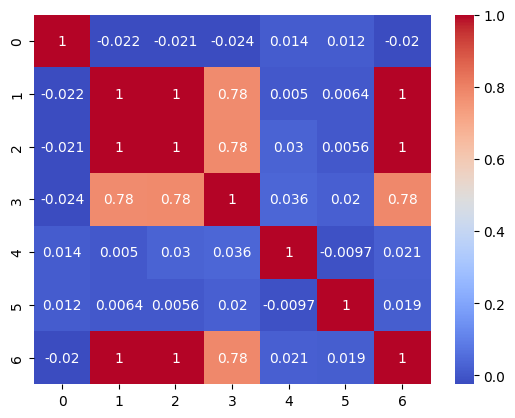

In [20]:
# examine relationships among five selected features, along with LogReturn and CloseLag1
XStudy = crm.select('LogReturn','CloseLag1','CloseLag3','HMLLag1','OMCLag2','OMCLag3','CloseEMA8')

# prepare correlation heat map using seaborn
corrMatrix = XStudy.corr()
print(corrMatrix)
sns.heatmap(corrMatrix, cmap='coolwarm', annot=True)
plt.show()

In [21]:
# select subset of five columns as features
X = crm.select('CloseLag3','HMLLag1','OMCLag2','OMCLag3','CloseEMA8')

### Define Cross-Validation Training and Test Sets
Recognizing that time series observations are not independent observations, we use Scikit-Learn [TimeSeriesSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html) for cross-validation. 

This cross-validation object is a variation of multi-fold cross-validation for independent observations. In the kth split, it returns first k folds as train set and the (k+1)th fold as test set.

Unlike cross-validation for independent observations, however, successive training sets are supersets of those that come before them. A listing of observation index numbers shows what this means for the time series market data in this demonstration.


In [22]:
# Splitting the datasets into train and test sets
# gap is the number of samples to exclude from 
# the end of each train set and before the next test set.
tscv = TimeSeriesSplit(gap=10, n_splits=5)

all_splits = list(tscv.split(X, y))
train_0, test_0 = all_splits[0]
train_1, test_1 = all_splits[1]
train_2, test_2 = all_splits[2]
train_3, test_3 = all_splits[3]
train_4, test_4 = all_splits[4]

# examine the objects created for cross-validation splits
print("type(all_splits):", type(all_splits), " outer list length", len(all_splits))
print()
print("train_0 has",len(train_0),"with indices from ",min(train_0),"to",max(train_0))
print("test_0 has",len(test_0),"with indices from ",min(test_0),"to",max(test_0))
print()
print("train_1 has",len(train_1),"with indices from ",min(train_1),"to",max(train_1))
print("test_1 has",len(test_1),"with indices from ",min(test_1),"to",max(test_1))
print()
print("train_2 has",len(train_2),"with indices from ",min(train_2),"to",max(train_2))
print("test_2 has",len(test_2),"with indices from ",min(test_2),"to",max(test_2))
print()
print("train_3 has",len(train_3),"with indices from ",min(train_3),"to",max(train_3))
print("test_3 has",len(test_3),"with indices from ",min(test_3),"to",max(test_3))
print()
print("train_4 has",len(train_4),"with indices from ",min(train_4),"to",max(train_4))
print("test_4 has",len(test_4),"with indices from ",min(test_4),"to",max(test_4))

# to see all indices we can uncomment these statements
# print("elements of all_splits list of lists,\n shows index numbers for each the five lists")
# print(all_splits)

type(all_splits): <class 'list'>  outer list length 5

train_0 has 873 with indices from  0 to 872
test_0 has 882 with indices from  883 to 1764

train_1 has 1755 with indices from  0 to 1754
test_1 has 882 with indices from  1765 to 2646

train_2 has 2637 with indices from  0 to 2636
test_2 has 882 with indices from  2647 to 3528

train_3 has 3519 with indices from  0 to 3518
test_3 has 882 with indices from  3529 to 4410

train_4 has 4401 with indices from  0 to 4400
test_4 has 882 with indices from  4411 to 5292


### Define an Initial Classification Model to Be Evaluated
We again select gradient boosting from the XGBoost package, this time defining a classification model to be evaluated. Hyperparameters are retained at defauld settings, except for n_estimators.

In [23]:
model = XGBClassifier(objective='binary:logistic', n_estimators=1000, random_state=2025)

### Evaluate a Classification Model Within the Time Series Cross-Validation Design
Prior to executing a full-blown search for the "best" classification model, we test the cross-validation design on a binary classification model, revising code provided in online documentation for Scikit-Learn: [Time-related feature engineerng](https://scikit-learn.org/stable/auto_examples/applications/plot_cyclical_feature_engineering.html#sphx-glr-auto-examples-applications-plot-cyclical-feature-engineering-py). In particular, we define appropriate metrics for assessing classification performance.

In [24]:
def evaluate(model, X, y, cv, model_prop=None, model_step=None):
    cv_results = cross_validate(
        model,
        X,
        y,
        cv=cv,
        scoring=["accuracy"],
        return_estimator=model_prop is not None,
    )
    if model_prop is not None:
        if model_step is not None:
            values = [
                getattr(m[model_step], model_prop) for m in cv_results["estimator"]
            ]
        else:
            values = [getattr(m, model_prop) for m in cv_results["estimator"]]
        print(f"Mean model.{model_prop} = {np.mean(values)}")
    accuracy = -cv_results["test_accuracy"]

    # print used in earlier testing
    # print(
    #    f"Mean Accuracy:     {-accuracy.mean():.3f} +/- {accuracy.std():.3f}\n"
    # )
    return (-accuracy.mean(), accuracy.std())
    
evaluate(model, X, y, cv=tscv, model_prop="n_estimators")



Mean model.n_estimators = 1000.0


(0.5083900226757369, 0.014494745409974499)

In [25]:
# print results from evaluate
accuracyMean, accuracyStd = evaluate(model, X, y, cv=tscv, model_prop="n_estimators")
print(
        f"Mean Accuracy:     {accuracyMean:.3f} +/- {accuracyStd:.3f}\n"
     )

Mean model.n_estimators = 1000.0
Mean Accuracy:     0.508 +/- 0.014



### Randomized Search for Hyperparameter Settings
We search for effective values on five XGBoost hyperparameters: **max_depth**, **min_child_weight**, **subsample**, **learning_rate**, and **n_estimators**.

In [26]:
# Randomized search to find the best set of hyperparameters

param_dist = {
    'max_depth': randint(3, 10),
    'min_child_weight': randint(1, 10),
    'subsample': uniform(0.5, 1),
    'learning_rate': uniform(0.01, 0.1),
    'n_estimators': randint(100, 1000),
}
xgb_model = xgb.XGBClassifier(objective='binary:logistic', use_label_encoder=False, eval_metric='logloss', random_state=2025)

random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=100, # Number of parameter settings that are sampled.
    scoring='accuracy',
    cv = TimeSeriesSplit(gap=10, n_splits=5),
    random_state=2025,
    n_jobs=-1 # Use all available cores
)

random_search.fit(X, y)

print("Best parameters:", random_search.best_params_)
print("Best score:", random_search.best_score_)

Best parameters: {'learning_rate': 0.05987453639123192, 'max_depth': 7, 'min_child_weight': 2, 'n_estimators': 274, 'subsample': 0.5727332118825823}
Best score: 0.5156462585034014


### Evaluate the Model
We define define an XGBoost subset model with these hyperparameter values and evaluate on the full data set.

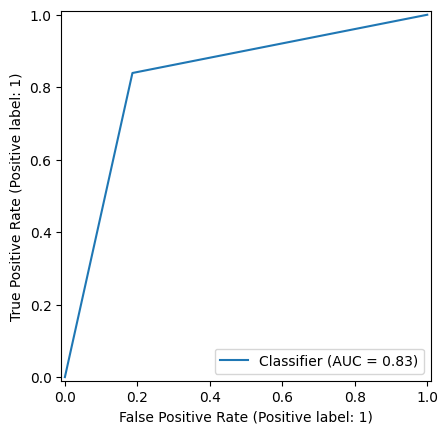

In [27]:
# final model evaluation
finalModel = XGBClassifier(objective='binary:logistic', eval_metric='logloss', random_state=2025,
                          max_depth = 9, min_child_weight = 9, subsample = 0.50, learning_rate = 0.09, n_estimators = 273)

finalModel.fit(X, y)
ypred = finalModel.predict(X)
RocCurveDisplay.from_predictions(y, ypred)
                    

Confusion Matrix
[[2100  481]
 [ 436 2276]]


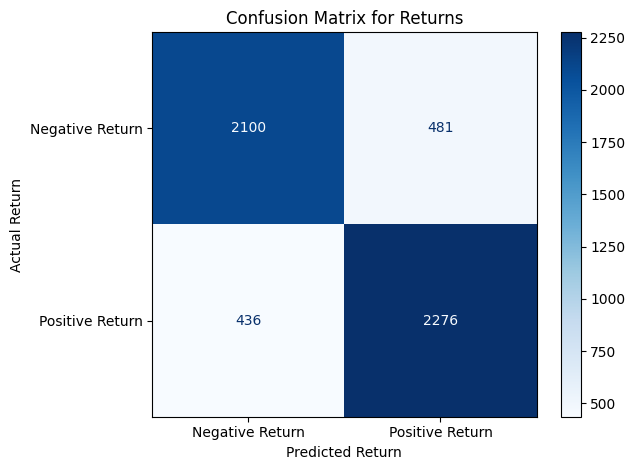

In [28]:
print("Confusion Matrix")
print(confusion_matrix(y, ypred))
disp = ConfusionMatrixDisplay.from_predictions(y, ypred,
                              display_labels =["Negative Return","Positive Return"],
                                              cmap = plt.cm.Blues)
plt.title("Confusion Matrix for Returns")
plt.xlabel("Predicted Return")
plt.ylabel("Actual Return")
plt.tight_layout()
plt.show()                              

In [29]:
print(classification_report(y, ypred, labels = ["0","1"]))

              precision    recall  f1-score   support

           0       0.83      0.81      0.82      2581
           1       0.83      0.84      0.83      2712

   micro avg       0.83      0.83      0.83      5293
   macro avg       0.83      0.83      0.83      5293
weighted avg       0.83      0.83      0.83      5293



## References

* [yfinance GitHub](https://github.com/ranaroussi/yfinance)
* [yfinance Documentation](https://ranaroussi.github.io/yfinance/)
* [Polars Online User Guide](https://docs.pola.rs/)
* [Build Polars Database](https://www.pyquantnews.com/free-python-resources/build-stock-database-locally-with-polars)
* [YouTube. Polars and Time Series: What It Can Do, and How to Overcome Any Limitation](https://www.youtube.com/watch?v=qz-zAHBz6Ks)
* [Awesome Quant: Python for Quantiative Finance](https://wilsonfreitas.github.io/awesome-quant/)
* [Cross-validation](https://scikit-learn.org/stable/modules/cross_validation.html)
* [TimeSeriesSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html)
* [RandomizedSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html)
* [Hyperparameter Tuning](https://scikit-learn.org/stable/modules/grid_search.html#grid-search)
* [Metrics and Scoring](https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter)
* [Introduction to Boosted Trees](https://xgboost.readthedocs.io/en/latest/tutorials/model.html)
* [XGBoost documentation](https://xgboost.readthedocs.io/en/latest/index.html)
* [XGBoost in Python documentation](https://xgboost-clone.readthedocs.io/en/latest/python/python_intro.html)
* [Auto-Sklearn for AutoML in an Scikit-Learn Environment](https://www.automl.org/automl-for-x/tabular-data/auto-sklearn/).